In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
import copy
import matplotlib.ticker as ticker
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.integrate import odeint
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
%matplotlib widget

if not os.path.exists('Figs'):
    os.mkdir('Figs')

In [2]:
svr = 0.174/2
D = 0.005
dosage = 1.04e-8 / (1-0.62)
pf = 43.078077317410866 # see prefactor notebook

In [3]:
def lighten(color, amount=1.8):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

### Equilibrium model

In [4]:
def concentration_tree(d, cfrac_smfrac):
    
    """
    d = total protein
    
    Concentrations described by a series of fractions (0-1)
    
    c (cfrac)
    s
        m (smfrac)
        n

    """
    
    cfrac, smfrac = [1 / (1 + np.exp(- i)) for i in cfrac_smfrac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac / (svr*D)
    n = s * (1 - smfrac) / (svr*D)  
    return c, m, n # concentrations


def calc_loss(cfrac_smfrac, dosage, ka, km, kn):

    # Concentrations
    c, m, n = concentration_tree(dosage, cfrac_smfrac)
        
    # Chemical potentials
    muc = np.log(c) - 0.5 * np.log(1 + 4 * ka * c + np.sqrt(1 + 8 * ka * c))
    mum = np.log(m) - 0.5 * np.log(1 + 4 * ka * m + np.sqrt(1 + 8 * ka * m)) - np.log(km)
    mun = np.log(n) - 0.5 * np.log(1 + 4 * ka * n + np.sqrt(1 + 8 * ka * n)) - np.log(kn)

    # Loss
    mu_all = np.array([muc, mum, mun])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)
        
    return loss


def func_equilibrium(km, ka, kn):

    # Optimise
    res = minimize(calc_loss, x0=[0, 0], args=(dosage, ka, km, kn)).x

    # Get concentrations
    c, m, n = concentration_tree(dosage, res)
    return [c, m, n]

###  Kinetic model

In [5]:
from scipy.integrate import odeint

def kon(c, km, ka, pf=pf):
    return pf / np.sqrt(1 + 4*c*ka + np.sqrt(1 + 8*c*ka))


def koff(m, km, ka, pf=pf):
    return pf / (km * np.sqrt(1 + 4*m*ka + np.sqrt(1 + 8*m*ka)))


def dxdt(X, ka, km, kn):
    c = X[0]
    m = X[1]
    n = X[2]

    r = np.zeros(4)
    r[0] = kon(c, km, ka) * c  # onto membrane
    r[1] = koff(m, km, ka) * m  # off membrane
    r[2] = kon(c, kn, ka) * c  # onto endosomes
    r[3] = koff(n, kn, ka) * n  # off endosomes

    dc = svr * D * (- r[0] + r[1] - r[2] + r[3])
    dm = + r[0] - r[1]
    dn = + r[2] - r[3]

    return dc, dm, dn

def func_kinetic(km, ka, kn, timepoints, x0=None):
    
    # Initial conditions
    if x0 is None:
        x0 = [dosage, 1e-100, 1e-100]

    # Solve
    def ode_func(X, t=0):
        return dxdt(X, ka=ka, km=km, kn=kn)

    sol = odeint(ode_func, x0, t=timepoints, atol=1e-10)
    return sol

### Changing wd

In [6]:
def _fake_log(x, pos):
    return r'$10^{%d}$' % (x)
fake_log = FuncFormatter(_fake_log)

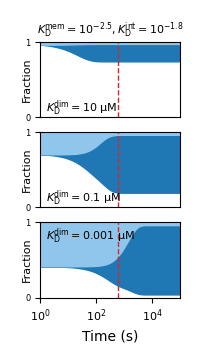

In [7]:
kn = 1.8
km = 2.5
ka_vals = [5, 7, 9]
tmin, tmax = 0, 5

timepoints = 10 ** np.linspace(tmin, tmax, 501)
sol0 = np.zeros([len(ka_vals), 3])
sol = np.zeros([len(ka_vals), len(timepoints), 3])
solinf = np.zeros([len(ka_vals), 3])
for i, ka in enumerate(ka_vals):
    
    # Time zero
    sol0[i, :] = func_equilibrium(km=1, ka=10 ** ka, kn=10 ** kn)
    
    # Timelapse
    sol[i, :, :] = func_kinetic(km=10 ** km, ka=10 ** ka, kn=10 ** kn, x0=sol0[i, :], timepoints=timepoints)
    
    # Time infinity
    solinf[i, :] = func_equilibrium(km=10 ** km, ka=10 ** ka, kn=10 ** kn)

    
fig, axs = plt.subplots(3, 1)
for i, (ax, s) in enumerate(zip(axs, sol)):
    ax.fill_between(x=np.log10(timepoints), y1=0, y2=s[:, 0]/ dosage, color='w')
    ax.fill_between(x=np.log10(timepoints), y1=s[:, 0] / dosage, 
                    y2=s[:, 0] / dosage + s[:, 1] * svr * D / dosage, color='tab:blue')
    ax.fill_between(x=np.log10(timepoints), y1=1, y2 = 1 - s[:, 2] * svr * D / dosage, color=lighten('tab:blue'))
    ax.set_ylim(0, 1)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Fraction', fontsize=8, labelpad=-5)
    ax.set_yticks([0, 1])
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.axvline(np.log10(600), linestyle='--', c='tab:red', linewidth=1)


axs[0].text(x=tmin + 0.2, y=0.07, s=r'$K\mathrm{_D^{dim}}=%s$' % 10**(-ka_vals[0]+6) + ' µM', fontsize=8)
axs[1].text(x=tmin + 0.2, y=0.07, s=r'$K\mathrm{_D^{dim}}=%s$' % 10**(-ka_vals[1]+6) + ' µM', fontsize=8)
axs[2].text(x=tmin + 0.2, y=0.77, s=r'$K\mathrm{_D^{dim}}=%s$' % 10**(-ka_vals[2]+6) + ' µM', fontsize=8)    
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].xaxis.set_major_formatter(fake_log)
axs[2].set_xlabel('Time (s)')
axs[0].set_title(r'$K\mathrm{_D^{mem}}=10^{%s}, K\mathrm{_D^{int}}=10^{%s}$' % (-km, -kn), fontsize=8)
fig.set_size_inches(2, 3.5)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig.savefig('Figs/timelapse.png', dpi=600, transparent=True)

### Pie chart grid

599.7910762555094
1.0000000000000004
0.9999999999999994
0.9999999999999997
1.0000000000000002
0.9999999999999998
0.9999999999999996
1.0000000000000009
0.9999999999999997
1.0000000000000007


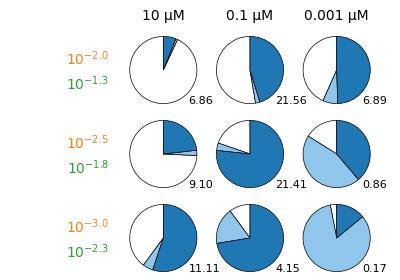

In [8]:
kas = [5, 7, 9]
kms = [2.0, 2.5, 3.0]

timepoints = 10 ** np.linspace(0, 6, 1001)
sol0 = np.zeros([len(kms), len(kas), 3])
sol = np.zeros([len(kms), len(kas), 3])
a = np.argmin(abs(timepoints - 600))
print(timepoints[a])
for i, km in enumerate(kms):
    for j, ka in enumerate(kas):
        sol0[i, j, :] = func_equilibrium(km=1, ka=10**ka, kn=10 ** (km - 0.7))
        sol[i, j, :] = func_kinetic(km=10**km, ka=10**ka, kn=10 ** (km - 0.7), x0=sol0[i, j, :], 
                                    timepoints=timepoints)[a]
   
def panel(ax, i, j):
    s = sol[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    n = s[2] * D * svr / dosage
    print(c + m + n)
    ax.pie([c, n, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})
    ratio = m / n
    ax.text(0.75, -1, f'{ratio:.2f}', fontsize=8)
    

fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title('%s µM' % (10**(-kas[0]+6)), fontsize=10) 
ax[0][1].set_title('%s µM' % (10**(-kas[1]+6)), fontsize=10) 
ax[0][2].set_title('%s µM' % (10**(-kas[2]+6)), fontsize=10) 

def set_ylabel(ax, km):
    ylabel1 = TextArea(r'$10^{%s}$' % (-km), textprops=dict(color="tab:orange", size=10, rotation=0, ha='center', 
                                                            va='center'))
    ylabel2 = TextArea(r'$10^{%s}$' % (-km + 0.7), textprops=dict(color="tab:green", size=10, rotation=0, ha='center',
                                                                  va='center'))
    ylabel = VPacker(children=[ylabel1, ylabel2], align="center", pad=0, sep=5)
    anchored_ybox = AnchoredOffsetbox(loc=8, child=ylabel, pad=0., frameon=False, bbox_to_anchor=(-0.4, 0.3), 
                                      bbox_transform=ax.transAxes, borderpad=0.)
    ax.add_artist(anchored_ybox)

set_ylabel(ax[0][0], kms[0]) 
set_ylabel(ax[1][0], kms[1]) 
set_ylabel(ax[2][0], kms[2]) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_mp.png', dpi=600, transparent=True)

### Pie chart grid - start

1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0


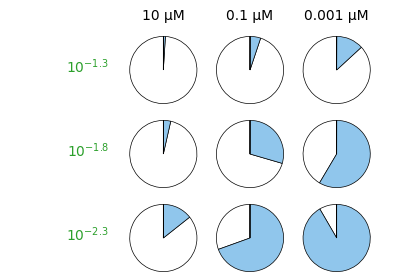

In [9]:
def panel(ax, i, j):
    s = sol0[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    n = s[2] * D * svr / dosage
    print(c + m + n)
    ax.pie([c, n, m], startangle=90, colors=['w', lighten('tab:blue'), 'tab:blue'], wedgeprops={'linewidth': 0.5, 
                                                                                         'edgecolor': 'k'})

fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title('%s µM' % (10**(-kas[0]+6)), fontsize=10) 
ax[0][1].set_title('%s µM' % (10**(-kas[1]+6)), fontsize=10) 
ax[0][2].set_title('%s µM' % (10**(-kas[2]+6)), fontsize=10) 

def set_ylabel(ax, km):
    ylabel = TextArea(r'$10^{%s}$' % (-km + 0.7), textprops=dict(color="tab:green", size=10, rotation=0, ha='center',
                                                                  va='center'))
    anchored_ybox = AnchoredOffsetbox(loc=8, child=ylabel, pad=0., frameon=False, bbox_to_anchor=(-0.4, 0.5), 
                                      bbox_transform=ax.transAxes, borderpad=0.)
    ax.add_artist(anchored_ybox)

set_ylabel(ax[0][0], kms[0]) 
set_ylabel(ax[1][0], kms[1]) 
set_ylabel(ax[2][0], kms[2]) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_pre_sb.png', dpi=600, transparent=True)

### Rates (for supplement)

In [10]:
# # Solve grid of equilibrium concentrations
# resolution = 20
# ka_mem_vals = np.linspace(1.75, 3.25, resolution)
# ka_int_vals = ka_mem_vals - 0.5
# ka_dim_vals = np.linspace(3, 11, resolution)

# supp_eq_concs = np.zeros([resolution, resolution, 3])
# for i, (ka_mem, ka_int) in enumerate(zip(ka_mem_vals, ka_int_vals)):
#     for j, ka_dim in enumerate(ka_dim_vals):
#         supp_eq_concs[i, j, :] = func_equilibrium(km=10 ** ka_mem, ka=10 ** ka_dim, kn=10 ** ka_int)

In [11]:
# # Evaluate on rate and off rates
# supp_kon = kon(supp_eq_concs[:, :, 0], km=None, ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)
# supp_koff_mem = koff(supp_eq_concs[:, :, 1], km=10 ** ka_mem_vals[..., np.newaxis], 
#                      ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)
# supp_koff_int = koff(supp_eq_concs[:, :, 2], km=10 ** ka_int_vals[..., np.newaxis], 
#                      ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)

In [12]:
# # Figures
# def func(array, title):
#     fig, ax = plt.subplots()
#     fig.set_size_inches(3, 2.5)
#     extent = (min(ka_dim_vals), max(ka_dim_vals), max(ka_mem_vals), min(ka_mem_vals))
#     aspect = abs(extent[1] - extent[0]) / abs(extent[3] - extent[2])
#     im = ax.imshow(np.log10(array), extent=extent, aspect=aspect, cmap='viridis')

#     for ka in kas:
#         for km in kms:
#             ax.scatter(ka, km, edgecolors='k', facecolors='w')
            
#     @FuncFormatter
#     def log_ka_to_kd(x, pos):
#         'The two args are the value and tick position'
#         return r'$10^{%.1f}$' % (-x)

#     @FuncFormatter
#     def log_ka_to_kd_molar_to_micromolar(x, pos):
#         'The two args are the value and tick position'
#         return r'$10^{%d}$' % (-x+6)
    
#     # Cbar
#     cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
#     cbar.ax.tick_params(labelsize=6)
#     cbar.ax.set_ylabel(title)

#     ax.yaxis.set_major_formatter(log_ka_to_kd)
#     ax.xaxis.set_major_formatter(log_ka_to_kd_molar_to_micromolar) 
#     ax.xaxis.tick_top()
#     ax.set_yticks(kms)
#     ax.set_xticks(kas)
#     ax.xaxis.set_label_position('top') 
#     ax.tick_params(axis='both', labelsize=7)
#     ax.set_xlabel(r'$K_D^{dim}$' + ' (µM)', fontsize=9)
#     ax.set_ylabel(r'$K_D^{mem}$', fontsize=9)
#     fig.subplots_adjust(left=0.22, top=0.8, right=0.8)

In [13]:
# func(supp_kon, r'$\log_{10}(k_{on})$')
# func(supp_koff_mem, r'$\log_{10}(k_{off})$')
# func(supp_koff_int, r'$\log_{10}(k_{off})$')

### Rates version 2 (no pm)

In [14]:
# Solve grid of equilibrium concentrations
resolution = 50
ka_mem_vals = np.linspace(1.8, 3.2, resolution)
ka_int_vals = ka_mem_vals - 0.7
ka_dim_vals = np.linspace(4, 10, resolution)

supp_eq_concs = np.zeros([resolution, resolution, 3])
for i, (ka_mem, ka_int) in enumerate(zip(ka_mem_vals, ka_int_vals)):
    for j, ka_dim in enumerate(ka_dim_vals):
        supp_eq_concs[i, j, :] = func_equilibrium(km=1, ka=10 ** ka_dim, kn=10 ** ka_int)
        
# fig, ax = plt.subplots()
# ax.imshow(supp_eq_concs[:, :, 1] /supp_eq_concs[:, :, 2])

In [15]:
# Evaluate on rate and off rates
supp_kon = kon(supp_eq_concs[:, :, 0], km=None, ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)
supp_koff_mem = koff(supp_eq_concs[:, :, 1], km=10 ** ka_mem_vals[..., np.newaxis], 
                     ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)
supp_koff_int = koff(supp_eq_concs[:, :, 2], km=10 ** ka_int_vals[..., np.newaxis], 
                     ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf)

In [16]:
# Figures
def func(array, title, filename=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(3.2, 2.8)
    extent = (min(ka_dim_vals), max(ka_dim_vals), max(ka_int_vals), min(ka_int_vals))
    aspect = abs(extent[1] - extent[0]) / abs(extent[3] - extent[2])
    im = ax.imshow(np.log10(array), extent=extent, aspect=aspect, cmap='viridis')

    for ka in kas:
        for km in kms:
            ax.scatter(ka, km-0.7, edgecolors='k', facecolors='w', s=10)
            
    @FuncFormatter
    def log_ka_to_kd(x, pos):
        'The two args are the value and tick position'
        return r'$10^{%.1f}$' % (-x)

    @FuncFormatter
    def log_ka_to_kd_molar_to_micromolar(x, pos):
        'The two args are the value and tick position'
        return r'$10^{%d}$' % (-x+6)
    
    # Cbar
    cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.set_ylabel(title)

    ax.yaxis.set_major_formatter(log_ka_to_kd)
    ax.xaxis.set_major_formatter(log_ka_to_kd_molar_to_micromolar) 
    ax.xaxis.tick_top()
    ax.set_yticks([i - 0.7 for i in kms])
    ax.set_yticklabels([])
    ax.set_xticks(kas)
    ax.set_xticklabels([])
    ax.xaxis.set_label_position('top') 
    ax.tick_params(axis='both', labelsize=7)
#     ax.set_xlabel(r'$K_D^{dim}$' + ' (µM)', fontsize=9, labelpad=10)
#     ax.set_ylabel(r'$K_D^{int}$', fontsize=9)
    fig.subplots_adjust(left=0.22, top=0.8, right=0.8, bottom=0.05)
    
    if filename is not None:
        fig.savefig('Figs/' + filename, dpi=600, transparent=True)

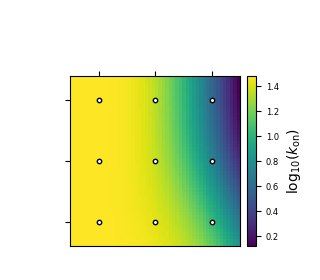

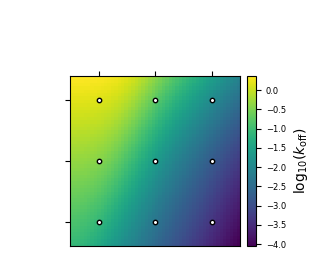

In [17]:
func(supp_kon, r'$\log_{10}(k_\mathrm{{on}})$', 'kon.png')
func(supp_koff_int, r'$\log_{10}(k_\mathrm{{off}})$', 'koff.png')

### Empty pie grid

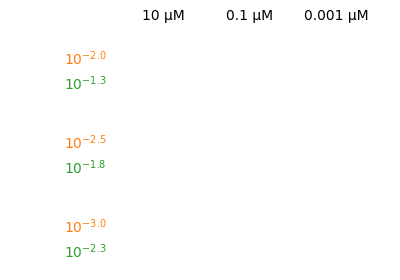

In [18]:
def panel(ax, i, j):
    ax.axis('off')

fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title('%s µM' % (10**(-kas[0]+6)), fontsize=10) 
ax[0][1].set_title('%s µM' % (10**(-kas[1]+6)), fontsize=10) 
ax[0][2].set_title('%s µM' % (10**(-kas[2]+6)), fontsize=10) 

def set_ylabel(ax, km):
    ylabel1 = TextArea(r'$10^{%s}$' % (-km), textprops=dict(color="tab:orange", size=10, rotation=0, ha='center', 
                                                            va='center'))
    ylabel2 = TextArea(r'$10^{%s}$' % (-km + 0.7), textprops=dict(color="tab:green", size=10, rotation=0, ha='center',
                                                                  va='center'))
    ylabel = VPacker(children=[ylabel1, ylabel2], align="center", pad=0, sep=5)
    anchored_ybox = AnchoredOffsetbox(loc=8, child=ylabel, pad=0., frameon=False, bbox_to_anchor=(-0.4, 0.3), 
                                      bbox_transform=ax.transAxes, borderpad=0.)
    ax.add_artist(anchored_ybox)

set_ylabel(ax[0][0], kms[0]) 
set_ylabel(ax[1][0], kms[1]) 
set_ylabel(ax[2][0], kms[2]) 

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig('Figs/pie_empty.png', dpi=600, transparent=True)

### Resistribution timescale

In [19]:
timepoints = 10 ** np.linspace(0, 6, 1001)
sol_timescale = np.zeros([len(ka_mem_vals), len(ka_dim_vals)])
residuals = np.zeros([len(ka_mem_vals), len(ka_dim_vals)])
for i, ka_mem in enumerate(ka_mem_vals):
    for j, ka_dim in enumerate(ka_dim_vals):
        sol = func_kinetic(km=10**ka_mem, ka=10**ka_dim, kn=10 ** (ka_mem - 0.7), 
                                                 x0=supp_eq_concs[i, j, :], timepoints=timepoints).T
        sol_final = func_equilibrium(km=10**ka_mem, ka=10**ka_dim, kn=10 ** (ka_mem - 0.7))
        conc50 = supp_eq_concs[i, j, 1] + 0.5 * (sol_final[1] - supp_eq_concs[i, j, 1])
        conc90 = supp_eq_concs[i, j, 1] + 0.9 * (sol_final[1] - supp_eq_concs[i, j, 1])
        sol_timescale[i, j] = timepoints[np.argmin(abs(sol[1, :] - conc90))]
        residuals[i, j] = np.min(abs(sol[1, :] - conc50))

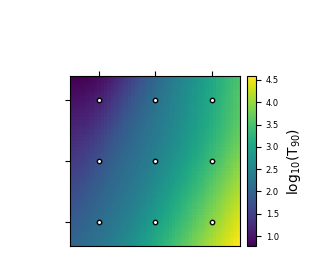

In [20]:
func(sol_timescale, r'$\log_{10}({\rm T}_{90})$', 'timescale.png')